In [2]:
import os, sys, gc, pickle
from pathlib import Path
from tqdm import tqdm, trange

import numpy as np
import pandas as pd
import torch as t

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from cluster_norm.utils.CCS import CCS
from cluster_norm.utils.CRC import CRC
from cluster_norm.utils.norm import normalize_burns, normalize_cluster


In [3]:
model, layer = "mistral", 23
variant = 1


experiment2_path = "/home/wombat_share/laurito/cluster_norm/src/cluster_norm/_experiment2"
outpath = f"{experiment2_path}/figures/{model}/layer{layer}"
Path(outpath).mkdir(exist_ok=True, parents=True)
prompts = pd.read_json(f"{experiment2_path}/prompts_positive.jsonl", 
                       orient="records", lines=True)
true_labels = prompts["label"].values == "positive"
alice_labels = prompts["alice"].values == "positive"

In [8]:
from sklearn.linear_model import LogisticRegression


variant = 1
for variant in [1, 2]:
    print(f"variant \n{variant}")
    pos = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_positive.pt")
    neg = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_negative.pt")
    split = int(0.7*len(pos))
    X_train, X_test = (pos-neg)[:split], (pos-neg)[split:]
    y_train_true, y_test_true = true_labels[:split], true_labels[split:]
    y_train_alice, y_test_alice = alice_labels[:split], alice_labels[split:]
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train_true)
    print("true", lr.score(X_test, y_test_true))
    lr = LogisticRegression(max_iter=10_000)
    lr.fit(X_train, y_train_alice)
    print("alice", lr.score(X_test, y_test_alice))

variant 
1
true 0.8783333333333333
alice 0.5183333333333333
variant 
2
true 0.855
alice 1.0


In [6]:
# CCS
print("CCS")

def get_crc(normalize):
    crc = CRC()
    accuracies, templates = [], []
    for variant in [1, 2]:
        pos = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_positive.pt")
        neg = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_negative.pt")
        split = int(0.7*len(pos))
        crc.fit(pos[:split], neg[:split], normalize)
        preds = crc.predict(pos[split:], neg[split:])
        true_acc = (preds == true_labels[split:]).mean()
        if (1-true_acc) > true_acc: true_acc = 1-true_acc
        alice_acc = (preds == alice_labels[split:]).mean()
        if (1-alice_acc) > alice_acc: alice_acc = 1-alice_acc
        accuracies.extend([true_acc, alice_acc])
        templates.extend([f"Default", f"Alice-opinion"])
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df

burns = get_crc("burns")
cluster = get_crc("cluster")

display(burns)
display(cluster)

CCS
CRC norm burns
CRC norm burns
CRC norm cluster
CRC norm cluster


,template,accuracy
0,Default,0.776667
1,Alice-opinion,0.508333
2,Default,0.686667
3,Alice-opinion,0.751667


,template,accuracy
0,Default,0.818333
1,Alice-opinion,0.513333
2,Default,0.693333
3,Alice-opinion,0.748333


PCA


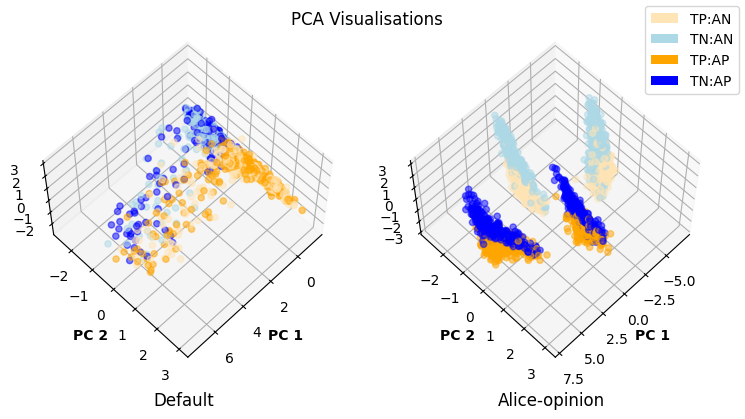

In [10]:
pca_legend_elements = [
    mpatches.Patch(facecolor="moccasin", label="TP:AN"),
    mpatches.Patch(facecolor="lightblue", label="TN:AN"),
    mpatches.Patch(facecolor="orange", label="TP:AP"),
    mpatches.Patch(facecolor="blue", label="TN:AP")
]
pca_colour_map = {
    (1, 0): "moccasin", # true positive, alice negative
    (0, 0): "lightblue", # true negative, alice negative
    (1, 1): "orange", # true positive, alice positive
    (0, 1): "blue", # true negative, alice positive
}
colours = [pca_colour_map[(l1, l2)] for l1, l2 in zip(true_labels, alice_labels)]


# PCA
print("PCA")

fig = plt.figure(figsize=(7.5, 4))
titles = ["Default", "Alice-opinion"]
for variant in [1, 2]:
    pos = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_positive.pt")
    neg = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_negative.pt")
    pca = PCA(n_components=3)
    X = pca.fit_transform(pos - neg)
    ax = fig.add_subplot(1, 2, variant, projection="3d")
    ax.view_init(elev=60, azim=45)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, c=colours)
    ax.set_xlabel("PC 1", weight="bold"); ax.set_ylabel("PC 2", weight="bold")
    ax.set_title(titles[variant-1], y=0, pad=-25, verticalalignment="top")
plt.suptitle("PCA Visualisations")
plt.figlegend(handles=pca_legend_elements)
plt.tight_layout()
plt.show()

In [13]:
# CCS
print("CCS")

def get_ccs(normalize):
    accuracies, templates = [], []
    for variant in [1, 2]:
        pos = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_positive.pt")
        neg = t.load(f"{experiment2_path}/activations/{model}/layer{layer}/variant{variant}_negative.pt")
        ccs = CCS(
            pos=pos,
            neg=neg,
            normalize=normalize,
            n_probe=50,
            device=t.device("cuda")
        )
        ccs.optimize()
        for probe in ccs.probes:
            preds = ccs.predict(probe, pos, neg)
            true_acc = (preds == true_labels).mean()
            if (1-true_acc) > true_acc: true_acc = 1-true_acc
            alice_acc = (preds == alice_labels).mean()
            if (1-alice_acc) > alice_acc: alice_acc = 1-alice_acc
            accuracies.extend([true_acc, alice_acc])
            templates.extend([f"Default", f"Alice-opinion"])
    df = pd.DataFrame()
    df["template"] = templates
    df["accuracy"] = accuracies
    return df

burns = get_ccs("burns")
cluster = get_ccs("cluster")

CCS
CCS norm burns


fitting probes: 100%|██████████| 5/5 [03:45<00:00, 45.18s/it]


CCS norm burns


fitting probes: 100%|██████████| 5/5 [03:57<00:00, 47.56s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [04:57<00:00, 59.43s/it]


CCS norm cluster


fitting probes: 100%|██████████| 5/5 [04:33<00:00, 54.76s/it]


In [14]:
display(burns)
display(cluster)

,template,accuracy
0,Default,0.8725
1,Alice-opinion,0.5090
2,Default,0.8765
3,Alice-opinion,0.5090
4,Default,0.8745
5,Alice-opinion,0.5090
6,Default,0.8755
7,Alice-opinion,0.5080
8,Default,0.8780
9,Alice-opinion,0.5095


,template,accuracy
0,Default,0.8945
1,Alice-opinion,0.5040
2,Default,0.8955
3,Alice-opinion,0.5040
4,Default,0.8955
5,Alice-opinion,0.5090
6,Default,0.8985
7,Alice-opinion,0.5030
8,Default,0.8980
9,Alice-opinion,0.5045


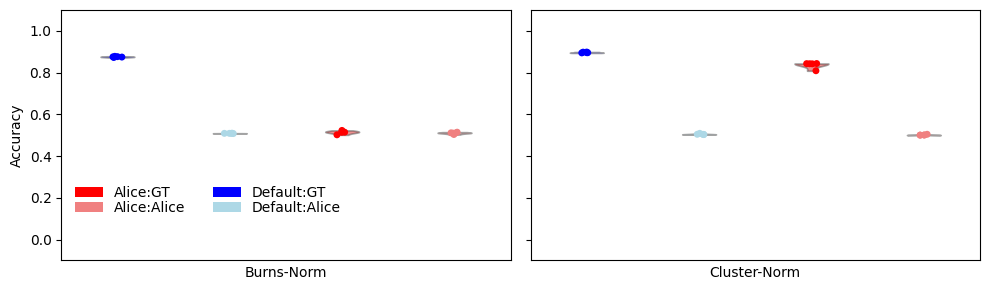

In [17]:
# burns = pd.read_csv(f"/gws/nopw/j04/ai4er/users/maiush/CN_gdrive/_experiment2/ccs/mistral/layer23/burns.csv")
# cluster = pd.read_csv(f"/gws/nopw/j04/ai4er/users/maiush/CN_gdrive/_experiment2/ccs/mistral/layer23/cluster.csv")

colours = {"Default:GT": "blue", "Default:Alice": "lightblue",
           "Alice:GT": "red", "Alice:Alice": "lightcoral"}
legend_elements = [
    mpatches.Patch(facecolor="red", label="Alice:GT"),
    mpatches.Patch(facecolor="lightcoral", label="Alice:Alice"),
    mpatches.Patch(facecolor="blue", label="Default:GT"),
    mpatches.Patch(facecolor="lightblue", label="Default:Alice")
]

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, squeeze=True, figsize=(10, 3))
for ax, df, label in zip(axs, [burns, cluster], ["Burns-Norm", "Cluster-Norm"]):
    df["template"] = ["Default:GT", "Default:Alice"]*5 + ["Alice:GT", "Alice:Alice"]*5
    sns.stripplot(x="template", y="accuracy", data=df, jitter=0.05, ax=ax, palette=colours, hue="template")
    sns.violinplot(x="template", y="accuracy", data=df, ax=ax, palette=colours, hue="template",
                cut=0, inner=None, width=0.3, alpha=0.5)
    ax.set_xticks([], [])
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(label)
axs[0].set_ylabel("Accuracy")
plt.figlegend(handles=legend_elements, loc="lower left", ncol=2, labelspacing=0.1,
              borderaxespad=5., frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()